In [1]:
import os
import cv2
import math
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset

In [2]:
import mxnet as mx
from mxnet import recordio

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
class CosFace(torch.nn.Module):
    def __init__(self, s=64.0, m=0.40):
        super(CosFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]
        final_target_logit = target_logit - self.m
        logits[index, labels[index].view(-1)] = final_target_logit
        logits = logits * self.s
        return logits

In [5]:
class CosFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = l2_norm(logits, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1])
        m_hot.scatter_(1, labels[index, None], self.m)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [6]:
# aa = CosFace(a, a)
# print(a)

In [7]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [9]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [10]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [11]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [13]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        layers = [conv_2d(3, 64, ks=7, stride=2)]
        layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
    
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        return self.features(x)

In [14]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [15]:
model = ResNet50(10)

In [16]:
model

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [17]:
def test():
    net = ResNet50(10)
    x = torch.randn(2, 3, 112, 300)
    y = net(x)
    print(y.shape)

In [18]:
test()

torch.Size([2, 10])


In [19]:
class ResNet_WIP(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += self.make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
                   #nn.Softmax(dim=1)]
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.features(x)

    def make_group(self, N, ni, nf, stride):
        start = ResBlock(ni, nf, stride)
        rest = [ResBlock2(nf, ni) for j in range(1, N)]
        return [start] + rest

# MS1M-ArcFace dataset

### For Windows system

In [20]:
# path_imgidx = 'D:/Face/faces_emore/train.idx'
# path_imgrec = 'D:/Face/faces_emore/train.rec'
# imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

# len(imgrec.keys)

### For Ubuntu system

In [21]:
path_imgidx = 'faces_emore/train.idx'
path_imgrec = 'faces_emore/train.rec'
imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

len(imgrec.keys)

5908396

In [22]:
imgrec.keys

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [23]:
list(imgrec.keys)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [24]:
np.array(list(imgrec.keys))

array([      1,       2,       3, ..., 5908394, 5908395,       0])

In [25]:
len(np.array(list(imgrec.keys)))

5908396

In [26]:
img_list = []

#%% 1 ~ 5908396, or 0~5908395, #85742 identities

for i in range(5908395):
    header, s = recordio.unpack(imgrec.read_idx(i+1))
#     img = mx.image.imdecode(s).asnumpy() 
#     plt.imshow(img)
#     print(img.shape)
#     plt.title('id=' + str(i) + ', label=' + str(header.label))
#     plt.pause(0.1)
    img_list.append(header.label)

In [27]:
len(img_list)

5908395

In [28]:
# img_list = np.array(img_list)
# print(np.unique(img_list))

In [29]:
_img_list = img_list[0:5822653]
__img_list = np.array(_img_list)
print(len(__img_list))
print(len(np.unique(__img_list)))

5822653
85742


In [30]:
# res_list = []

# for item in _img_list:
#     if item not in res_list:
#         res_list.append(item)

# print("Unique elements of the list using append():")
# print(len(res_list))

# #for item in res_list: 
# #    print(item)

In [31]:
5908395 - 5822653

85742

In [32]:
img_list[5822653]

array([  1., 111.], dtype=float32)

In [33]:
img_list[5822654]

array([111., 130.], dtype=float32)

Text(0.5, 1.0, 'id=1000, label=13.0')

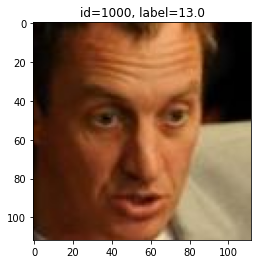

In [34]:
idx1 = 1000 #5908395
header1, s1 = recordio.unpack(imgrec.read_idx(idx1))

img1 = mx.image.imdecode(s1).asnumpy()
plt.imshow(img1)
plt.title('id=' + str(idx1) + ', label=' + str(header1.label))

Text(0.5, 1.0, 'id=5822656, label=[130. 213.]')

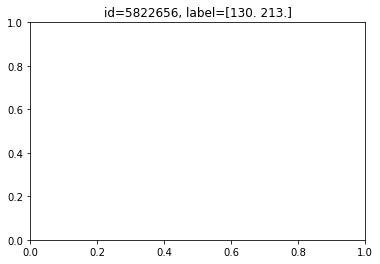

In [35]:
idx = 5822656
header, s = recordio.unpack(imgrec.read_idx(idx))

#img = mx.image.imdecode(s).asnumpy()
#plt.imshow(img)
plt.title('id=' + str(idx) + ', label=' + str(header.label))

In [36]:
header.flag

2

In [37]:
header.label

array([130., 213.], dtype=float32)

In [38]:
header0 = (int(header.label[0]), int(header.label[1]))
header0

(130, 213)

In [39]:
np.array(range(1, int(header.label[0])))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129])

In [40]:
len(np.array(range(1, int(header.label[0]))))

129

In [41]:
len(np.array(range(1, int(header.label[1]))))

212

In [42]:
class ArcFaceDataset(Dataset):
    def __init__(self, root_dir):
        super(ArcFaceDataset, self).__init__()

        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        
        self.root_dir = root_dir
        #root_dir2 = "D:/Face/faces_emore/" #"faces_emore/"
        
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

In [43]:
root_dir1 = "faces_emore/" #For Ubuntu
root_dir2 = "D:/Face/faces_emore/" #For Windows

dataset = ArcFaceDataset(root_dir1)

In [44]:
dataset

In [45]:
len(dataset)

5822653

In [46]:
img, label = dataset[5822652]
print(img.shape, label)

img = torch.reshape(img, (112, 112, 3))
print(img.shape)

torch.Size([3, 112, 112]) tensor(85741)
torch.Size([112, 112, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label=tensor(85741)')

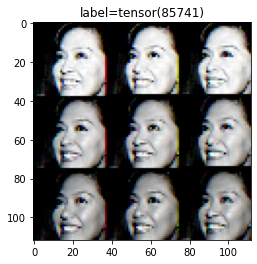

In [47]:
plt.imshow(img)
plt.title('label=' + str(label))

In [48]:
random_seed = 42
torch.manual_seed(random_seed);

In [49]:
test_factor = 0.1
test_size = int(test_factor * len(dataset))
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(dataset))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [50]:
len(train_ds), len(val_ds), len(test_ds)

(4658123, 582265, 582265)

In [51]:
batch_size=128

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [53]:
device = get_default_device()

In [54]:
device

device(type='cuda')

In [55]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [56]:
train_dl

In [57]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [58]:
len(train_dl), len(val_dl), len(test_dl)

(36392, 2275, 2275)

In [59]:
for images, labels in test_dl:
    #print("Inside")
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 112, 112])
out.shape: torch.Size([256, 10])
out[0]: tensor([-0.1956, -0.0914, -0.0953, -0.0919,  0.1122, -0.2263,  0.2888, -0.2454,
        -0.1202, -0.2993], device='cuda:0', grad_fn=<SelectBackward0>)


In [60]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    preds = model(xb)
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #update parameters
        opt.step()
        #Reset Gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

In [61]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [62]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
    
    return train_losses, val_losses, val_metrics

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [ ]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric=accuracy)

In [ ]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

In [ ]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 0.005

In [ ]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, lr, accuracy, opt_func)

In [ ]:
train_losses, val_losses, val_metrics = history

In [ ]:
def plot_accuracies(val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    plt.plot(val_metrics, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(val_metrics)

In [ ]:
def plot_losses(train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
result = evaluate(model, F.cross_entropy, test_dl, accuracy)
result

In [ ]:
torch.save(model.state_dict(), 'el.pth')

### Dummy code

In [ ]:
k = nn.Parameter(torch.FloatTensor(3, 5))
k

In [ ]:
a = torch.Tensor([[1, 2, 3], [3, -4, -2]])
b = torch.Tensor([[1, 2, 3, 4], [3, 4, 1, 0], [5, 6, 1, 1]])

In [ ]:
a = torch.FloatTensor([1, 2])

In [ ]:
a.dtype

In [ ]:
c = torch.mm(a, b)
c.shape

In [ ]:
c

In [ ]:
c.size()

In [ ]:
e = c.clamp(-1, 1)

In [ ]:
e

In [ ]:
dirty = e > 0
dirty

In [ ]:
dirty = dirty.float()
dirty

In [ ]:
index = torch.where(c != -1)[0]
index

In [ ]:
index.size(0)

In [ ]:
index.size()[0]

In [ ]:
torch.zeros(index.size()[0], c.size()[1])

In [ ]:
def abc(a: int, logits):# torch.Tensor):
    print(a)
    print(logits)

In [ ]:
abc(5, c)

In [ ]:
k = [[1, 2, 3], [2, 3, 1]]
abc(5, k)

In [ ]:
k = [[1, 2, 3], [2, 3, 1]]
abc(5.2, 4)

In [ ]:
c.view(-1)

In [ ]:
#----

In [ ]:
logits = torch.Tensor([[1, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0]]) #torch.Tensor([10, 2, 3, 5])
labels = torch.Tensor([[1, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 0, 1]])

index = torch.where(labels != -1)[0]
index

In [ ]:
print(logits.dtype)
print(labels.dtype)
print(index.dtype)

In [ ]:
labels[index]

In [ ]:
l = labels[index].view(-1)
l

In [ ]:
l = l.int()
l

In [ ]:
t = logits[index, index]

In [ ]:
t

In [64]:
class Sub:
    def __init__(self, name):
        super(Sub, self).__init__() #Another way to fix  this
        self.name=name
        

a = Sub("Harry")
a.name

'Harry'

In [65]:
isinstance([1, 2], numbers.Number)

False

In [66]:
a = torch.tensor(65.5, dtype=torch.long)
a

tensor(65)